----

In [1]:
from pathlib import Path
from kilosort.io import load_ops

import spikeinterface as si
import matplotlib.pyplot as plt
%matplotlib inline
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

global_job_kwargs = dict(n_jobs = 4)
si.set_global_job_kwargs(**global_job_kwargs)

/home/ubuntu/.conda/envs/spike_sorting_jct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_best_channels(results_dir):
    """Get channel numbers with largest template norm for each cluster."""
    templates = np.load(results_dir + '/templates.npy')
    best_chans = (templates**2).sum(axis=1).argmax(axis=-1)
    return best_chans

In [3]:
def get_spike_inf(file_path):
    cluster_inf = pd.read_csv(file_path + "/analyzer_kilosort4_binary/extensions/quality_metrics/metrics.csv")
    cluster_inf.columns = ['cluster', 'num_spikes', 'firing_rate', 'presence_ratio', 'snr',
       'isi_violations_ratio', 'isi_violations_count', 'rp_contamination',
       'rp_violations', 'sliding_rp_violation', 'amplitude_cutoff',
       'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
       'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'firing_range',
       'drift_ptp', 'drift_std', 'drift_mad', 'sd_ratio']
    cluster_inf['cluster'] = cluster_inf['cluster'].astype(str)
    cluster_inf['position_1'] = None
    cluster_inf['position_2'] = None

    def get_best_channels(results_dir):
        """Get channel numbers with largest template norm for each cluster."""
        templates = np.load(results_dir + '/templates.npy')
        best_chans = (templates**2).sum(axis=1).argmax(axis=-1)
        return best_chans
    best_chans = get_best_channels(results_dir=file_path + "/kilosort4/sorter_output")
    cluster_inf['best_chans'] = best_chans

    spike_clusters = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_clusters.npy").astype(str))
    spike_positions = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_positions.npy").astype(float))
    spike_templates = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_templates.npy"))
    spike_times = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_times.npy").astype(int))
    tf = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/tF.npy")[:, 0, :])

    spike_inf = pd.concat((spike_clusters, spike_positions, spike_templates, spike_times, tf), axis=1)
    spike_inf.columns = ['cluster', 'position_1', 'position_2', 'templates', 'time', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6']

    for i in spike_inf['cluster'].value_counts().index:
        temp = spike_inf[spike_inf['cluster'] == i]
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_1'] = np.mean(temp['position_1'])
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_2'] = np.mean(temp['position_2'])
    
    cluster_inf['probe_group'] = "1"

    for i in spike_inf['cluster'].value_counts().index:
        cluster_rows = cluster_inf[cluster_inf['cluster'] == i]
        if (cluster_rows['position_1'] > 100).any() and (cluster_rows['position_1'] < 250).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "2"
        elif (cluster_rows['position_1'] > 250).any() and (cluster_rows['position_1'] < 400).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "3"
        elif (cluster_rows['position_1'] > 400).any() and (cluster_rows['position_1'] < 550).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "4"
        elif (cluster_rows['position_1'] > 550).any() :
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "5"
    
    spike_inf['neuron'] = None

    cluster_potent_inf = cluster_inf[(cluster_inf['snr'] > 3) | ((cluster_inf['num_spikes'] > 5000) & (cluster_inf['num_spikes'] <= 8000))]
    cluster_inf = cluster_inf[((cluster_inf['snr'] > 3) & (cluster_inf['num_spikes'] > 8000)) | ((cluster_inf['snr'] < 3) & (cluster_inf['num_spikes'] > 8000))]

    spike_potent_inf = spike_inf[spike_inf['cluster'].isin(list(cluster_potent_inf['cluster']))]
    spike_inf = spike_inf[spike_inf['cluster'].isin(list(cluster_inf['cluster']))]

    return cluster_inf, spike_inf, cluster_potent_inf, spike_potent_inf

In [38]:
cluster_inf, spike_inf, cluster_potent_inf, spike_potent_inf = get_spike_inf(file_path="/media/ubuntu/sda/data/mouse6/output/sorting_natural_image_new/022522")

In [ ]:
similarity = np.load("/media/ubuntu/sda/data/mouse6/output/sorting_natural_image_new/022522/phy_folder_for_kilosort/similar_templates.npy")

In [40]:
similarity = pd.DataFrame(similarity, columns=range(len(similarity)))
similarity.index = range(len(similarity))

similarity = similarity.loc[cluster_inf['cluster'].value_counts().index.astype(int), cluster_inf['cluster'].value_counts().index.astype(int)]

In [ ]:
indices = np.where((similarity > 0.9) & (similarity < 1))
pairs = list(zip(similarity.index[indices[0]], similarity.columns[indices[1]]))
lower_triangle_pairs = [(row, col) for row, col in pairs if similarity.index.get_loc(row) < similarity.columns.get_loc(col)]
pairs = [[str(row), str(col)] for row, col in lower_triangle_pairs]

[['9', '11'], ['14', '15'], ['16', '17']]

In [ ]:
for a, b in pairs:
    row_a = cluster_inf[cluster_inf['cluster'] == a]
    row_b = cluster_inf[cluster_inf['cluster'] == b]
    
    if not row_a.empty and not row_b.empty:
        cluster_inf.loc[cluster_inf['cluster'] == a, 'num_spikes'] += row_b['num_spikes'].values[0]
        cluster_inf = cluster_inf[cluster_inf['cluster'] != b]


for a, b in pairs:
    spike_inf.loc[spike_inf['cluster'] == b, 'cluster'] = a

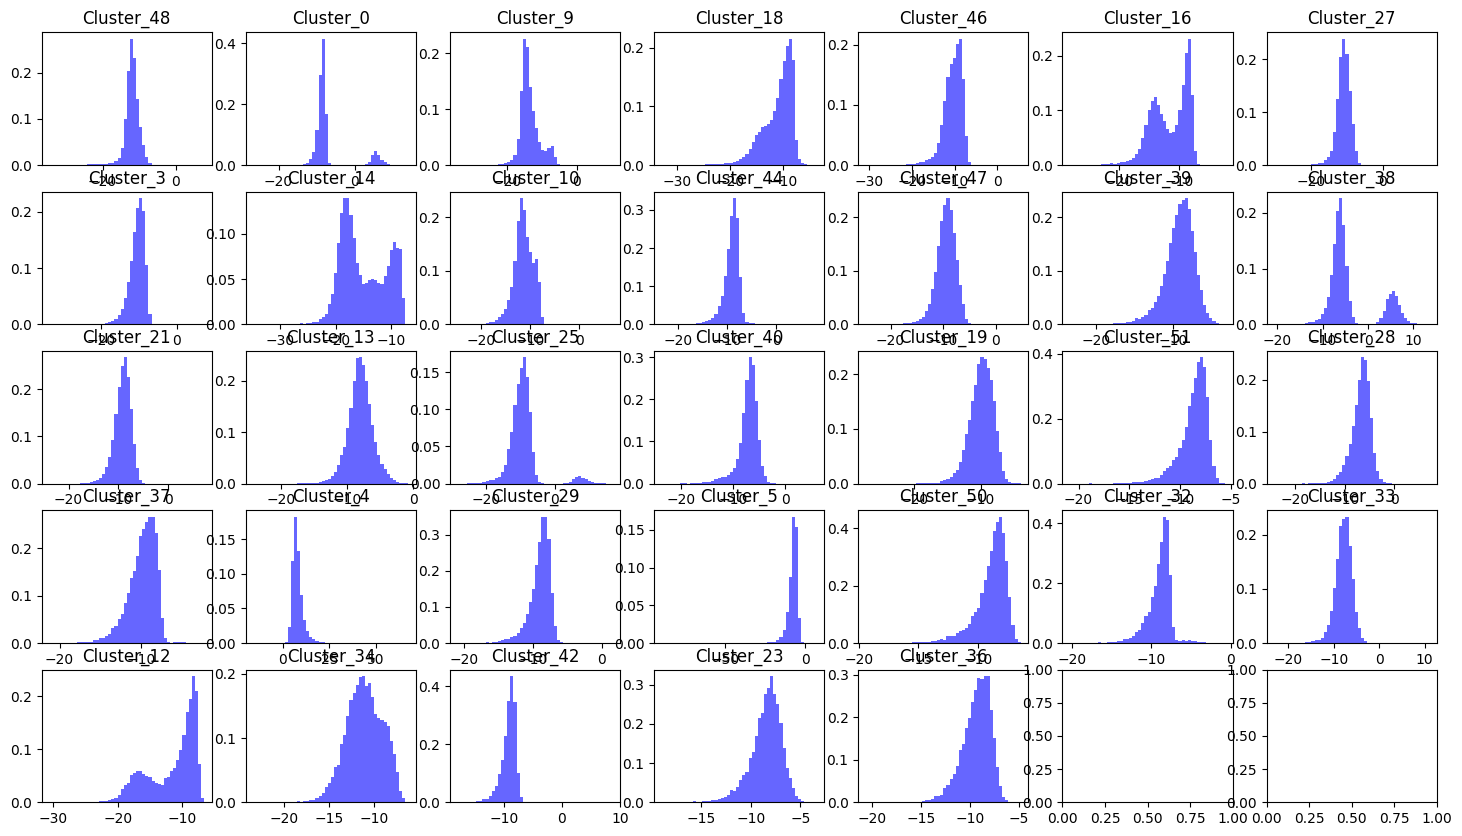

In [6]:
#判断是否为2峰分布
fig, axes = plt.subplots(5, 7, figsize=(18, 10))  
axes = axes.flatten()  

num = 0
for cluster in spike_inf['cluster'].value_counts().index:
    ax = axes[num]
    temp = spike_inf[spike_inf['cluster'] == cluster]

    ax.hist(temp['PC_1'], bins=50, density=True, alpha=0.6, color='b', label='Histogram')
    ax.set_title(f'Cluster_{cluster}')
    num += 1
plt.show()


In [7]:
spike_inf = spike_inf[~((spike_inf['cluster'] == '0') & (spike_inf['PC_1'] > 0))]
spike_inf = spike_inf[~((spike_inf['cluster'] == '25') & (spike_inf['PC_1'] > 0))]

In [8]:
spike_inf['cluster_devide'] = spike_inf['cluster']
spike_inf.loc[(spike_inf['PC_1'] > 0) & (spike_inf['cluster'] == '38'), 'cluster_devide'] = '38_1'

temp = spike_inf[spike_inf['cluster'] == "38"]
cluster_inf.loc[cluster_inf['cluster'] == '38', 'num_spikes'] = temp['cluster_devide'].value_counts()[0]
cluster_temp = cluster_inf[cluster_inf['cluster'] == '38']
cluster_temp['cluster'] = '38_1'
cluster_temp['num_spikes'] = temp['cluster_devide'].value_counts()[1]
cluster_inf = pd.concat((cluster_inf, cluster_temp))



In [10]:
fig, axes = plt.subplots(5, 5, figsize=(35, 35))  
axes = axes.flatten()  

num = 0

for group in cluster_inf['probe_group'].value_counts().index:
    clusters = list(cluster_inf.loc[cluster_inf['probe_group'] == group, 'cluster'])
    temp = spike_inf[spike_inf['cluster'].isin(clusters)]

    ax = axes[num]

    sns.scatterplot(x = temp['PC_1'], y = temp['PC_2'], hue=temp['cluster'], ax=ax, size=1)

    num += 1

for group in cluster_inf['probe_group'].value_counts().index:
    clusters = list(cluster_inf.loc[cluster_inf['probe_group'] == group, 'cluster'])
    temp = spike_inf[spike_inf['cluster'].isin(clusters)]

    ax = axes[num]

    sns.scatterplot(x = temp['PC_1'], y = temp['PC_3'], hue=temp['cluster'], ax=ax, size=1)

    num += 1

for group in cluster_inf['probe_group'].value_counts().index:
    clusters = list(cluster_inf.loc[cluster_inf['probe_group'] == group, 'cluster'])
    temp = spike_inf[spike_inf['cluster'].isin(clusters)]

    ax = axes[num]

    sns.scatterplot(x = temp['PC_1'], y = temp['PC_4'], hue=temp['cluster'], ax=ax, size=1)

    num += 1

for group in cluster_inf['probe_group'].value_counts().index:
    clusters = list(cluster_inf.loc[cluster_inf['probe_group'] == group, 'cluster'])
    temp = spike_inf[spike_inf['cluster'].isin(clusters)]

    ax = axes[num]

    sns.scatterplot(x = temp['PC_1'], y = temp['PC_5'], hue=temp['cluster'], ax=ax, size=1)

    num += 1

for group in cluster_inf['probe_group'].value_counts().index:
    clusters = list(cluster_inf.loc[cluster_inf['probe_group'] == group, 'cluster'])
    temp = spike_inf[spike_inf['cluster'].isin(clusters)]

    ax = axes[num]

    sns.scatterplot(x = temp['PC_1'], y = temp['PC_6'], hue=temp['cluster'], ax=ax, size=1)

    num += 1
plt.savefig("022522_pca_raw.png")
plt.close()

In [11]:
def get_spike_waveforms(spikes, results_dir, bfile=None, chan=None):
    """Get waveform for each spike in `spikes`, multi- or single-channel.
    
    Parameters
    ----------
    spikes : list or array-like
        Spike times (in units of samples) for the desired waveforms, from
        `spike_times.npy`.
    results_dir : str or Path
        Path to directory where Kilosort4 sorting results were saved.
    bfile : kilosort.io.BinaryFiltered; optional
        Kilosort4 data file object. By default, this will be loaded using the
        information in `ops.npy` in the saved results.
    chan : int; optional.
        Channel to use for single-channel waveforms. If not specified, all
        channels will be returned.

    Returns
    -------
    waves : np.ndarray
        Array of spike waveforms with shape `(nt, len(spikes))`.
    
    """
    if isinstance(spikes, int):
        spikes = [spikes]

    if bfile is None:
        ops = io.load_ops(results_dir + '/ops.npy')
        bfile = io.bfile_from_ops(ops)
    whitening_mat_inv = np.load(results_dir + '/whitening_mat_inv.npy')

    waves = []
    for t in spikes:
        tmin = t - bfile.nt0min
        tmax = t + (bfile.nt - bfile.nt0min)
        w = bfile[tmin:tmax].cpu().numpy()
        if whitening_mat_inv is not None:
            w = whitening_mat_inv @ w
        if w.shape[1] == bfile.nt:
            # Don't include spikes at the start or end of the recording that
            # get truncated to fewer time points.
            waves.append(w)
    waves = np.stack(waves, axis=-1)

    if chan is not None:
        waves = waves[chan,:]
    
    bfile.close()

    return waves

In [12]:
spike_inf = spike_inf[spike_inf['time'] > 100]

In [13]:
from kilosort import io
waveform_dict = {}
for cluster in cluster_inf['cluster'].value_counts().index:
    temp = spike_inf[spike_inf['cluster_devide'] == cluster]
    best_chan = cluster_inf.loc[cluster_inf['cluster'] == cluster, 'best_chans']
    waveform_dict[cluster] = get_spike_waveforms(spikes=list(temp['time']), results_dir="/media/ubuntu/sda/data/mouse6/output/sorting_natural_image_new/022522/kilosort4/sorter_output", chan=best_chan)

In [16]:
waveform_mean = pd.DataFrame()
for cluster, df in waveform_dict.items():
    waveform_mean = pd.concat((waveform_mean, pd.DataFrame(np.mean(df, axis=2)[0], columns=[cluster])), axis=1)

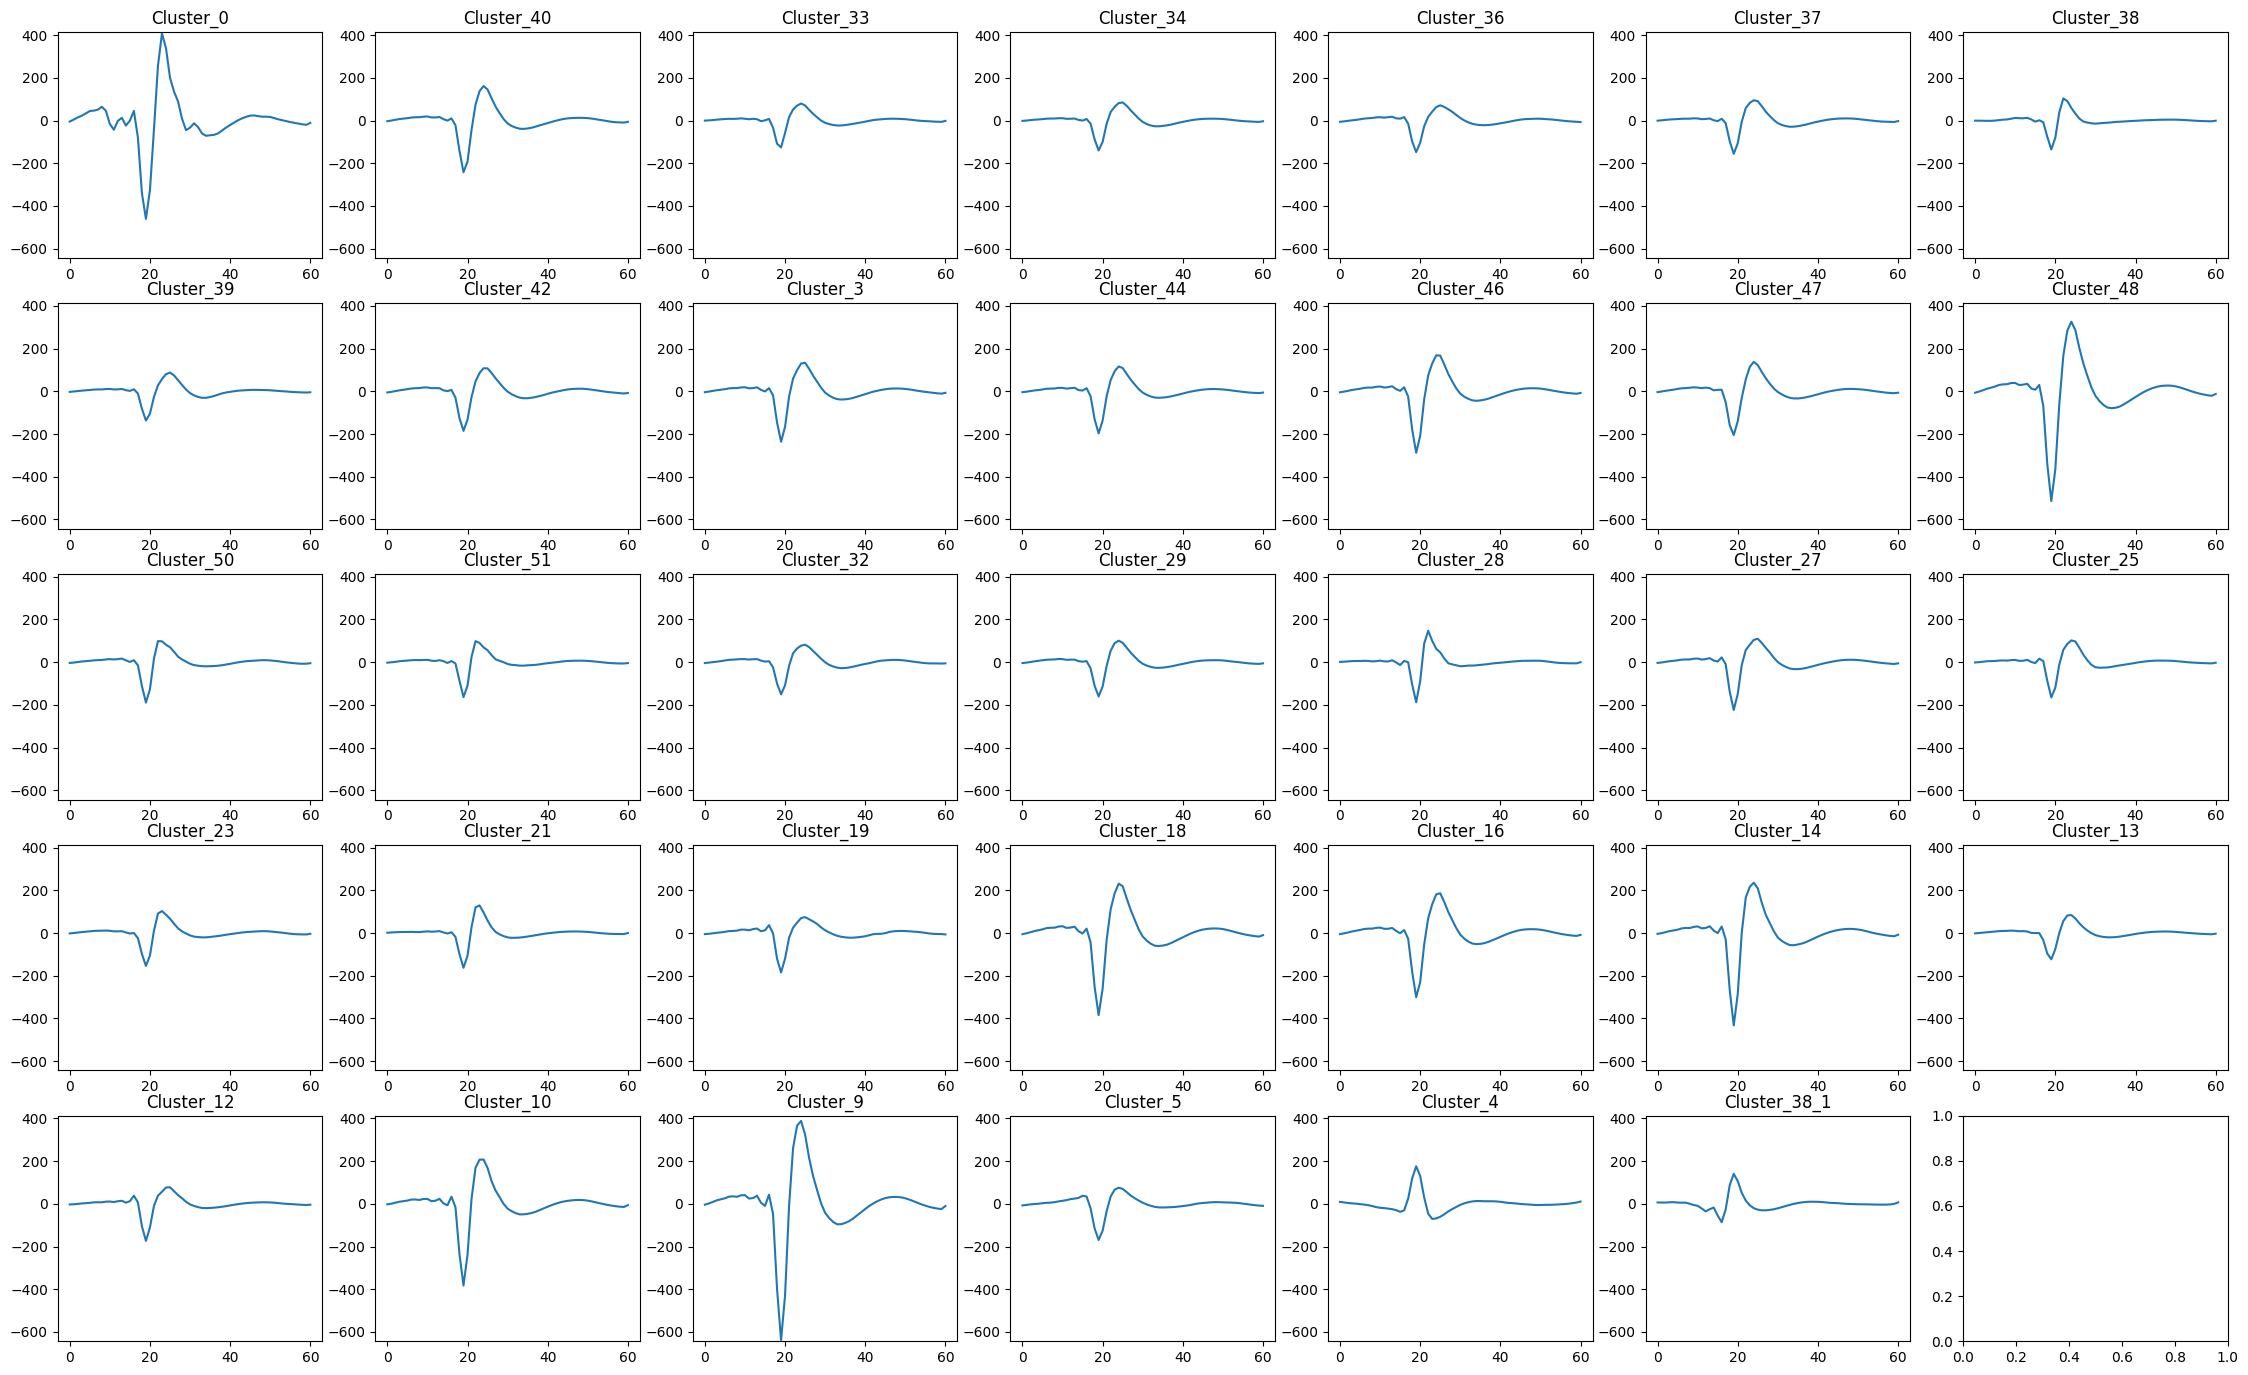

In [17]:
fig, axes = plt.subplots(5, 7, figsize=(28, 17))  
axes = axes.flatten()  

max = waveform_mean.max().max()+5
min = waveform_mean.min().min()-5
for i in range(waveform_mean.shape[1]):
    ax = axes[i]

    sns.lineplot(x = range(61),
                 y = waveform_mean.iloc[:, i],
                 ax=ax)
    ax.set_title(f'Cluster_{waveform_mean.columns[i]}')
    ax.set_ylabel("")
    ax.set_ylim(min, max)

plt.show()

In [18]:
cluster_inf.to_csv("cluster_inf.tsv", sep = '\t')
spike_inf.to_csv('spike_inf.tsv', sep='\t')
cluster_potent_inf.to_csv('cluster_potent_inf.tsv', sep='\t')
spike_potent_inf.to_csv('spike_potent_inf.tsv', sep='\t')
waveform_mean.to_csv('waveform_mean.tsv', sep='\t')